In [1]:
%matplotlib inline

from pathlib import Path
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from unidecode import unidecode

DATA_EXT = (Path(os.getcwd()) / os.pardir / 'data' / 'external').resolve()

In [2]:
import sys
sys.path.append(os.path.join(os.getcwd(), os.pardir, 'src'))

%load_ext autoreload

%autoreload 2
from visualization.visualize import *
from data.geo_utils import canonicalize_dataframe_geographies

In [3]:
who_df = pd.read_csv(Path('../data/interim/calc_cols_added.csv'), index_col=0)
who_df.head(2)

,Iso Code,Country Name,WHO Region,Year,Vaccine Type,Admin1,Admin2,DenomType,Denominator,Numerator,Coverage,recalc_numerator,available_admin,normalized_country,indicator,group,vaccine,timing,reported
0,AFG,Afghanistan,EMRO,2016,BCG,NaN,Aab Band,1.0,1266.0,NaN,51.801245,655.803767,Aab Band,afghanistan,1,BCG,BCG,1st_birth,True
1,AFG,Afghanistan,EMRO,2016,BCG,NaN,Aab Kamari,1.0,4599.0,NaN,94.674670,4354.088093,Aab Kamari,afghanistan,1,BCG,BCG,1st_birth,True


In [4]:
code_to_name = (who_df[['Iso Code', 'Country Name']].drop_duplicates()
                                                    .set_index('Iso Code')
                                                    .to_dict()['Country Name'])

### Coefficient of Variation, recalced numerators

In [5]:
# numerator error, adminstered at same time
coef_var = (who_df.groupby(['Iso Code', 'available_admin', 'timing'])
                  .recalc_numerator
                  .agg(['mean', 'std'])
                  .assign(coef_of_var=lambda x: x['std'] / x['mean'])
                  .dropna()
                  .reset_index()
                  .groupby('Iso Code')
                  .coef_of_var
                  .mean()
                  .dropna()
                  .sort_values(ascending=False))

coef_var.to_frame().to_csv(Path('../data/processed/scores/country-internal-coef_of_var.csv'))

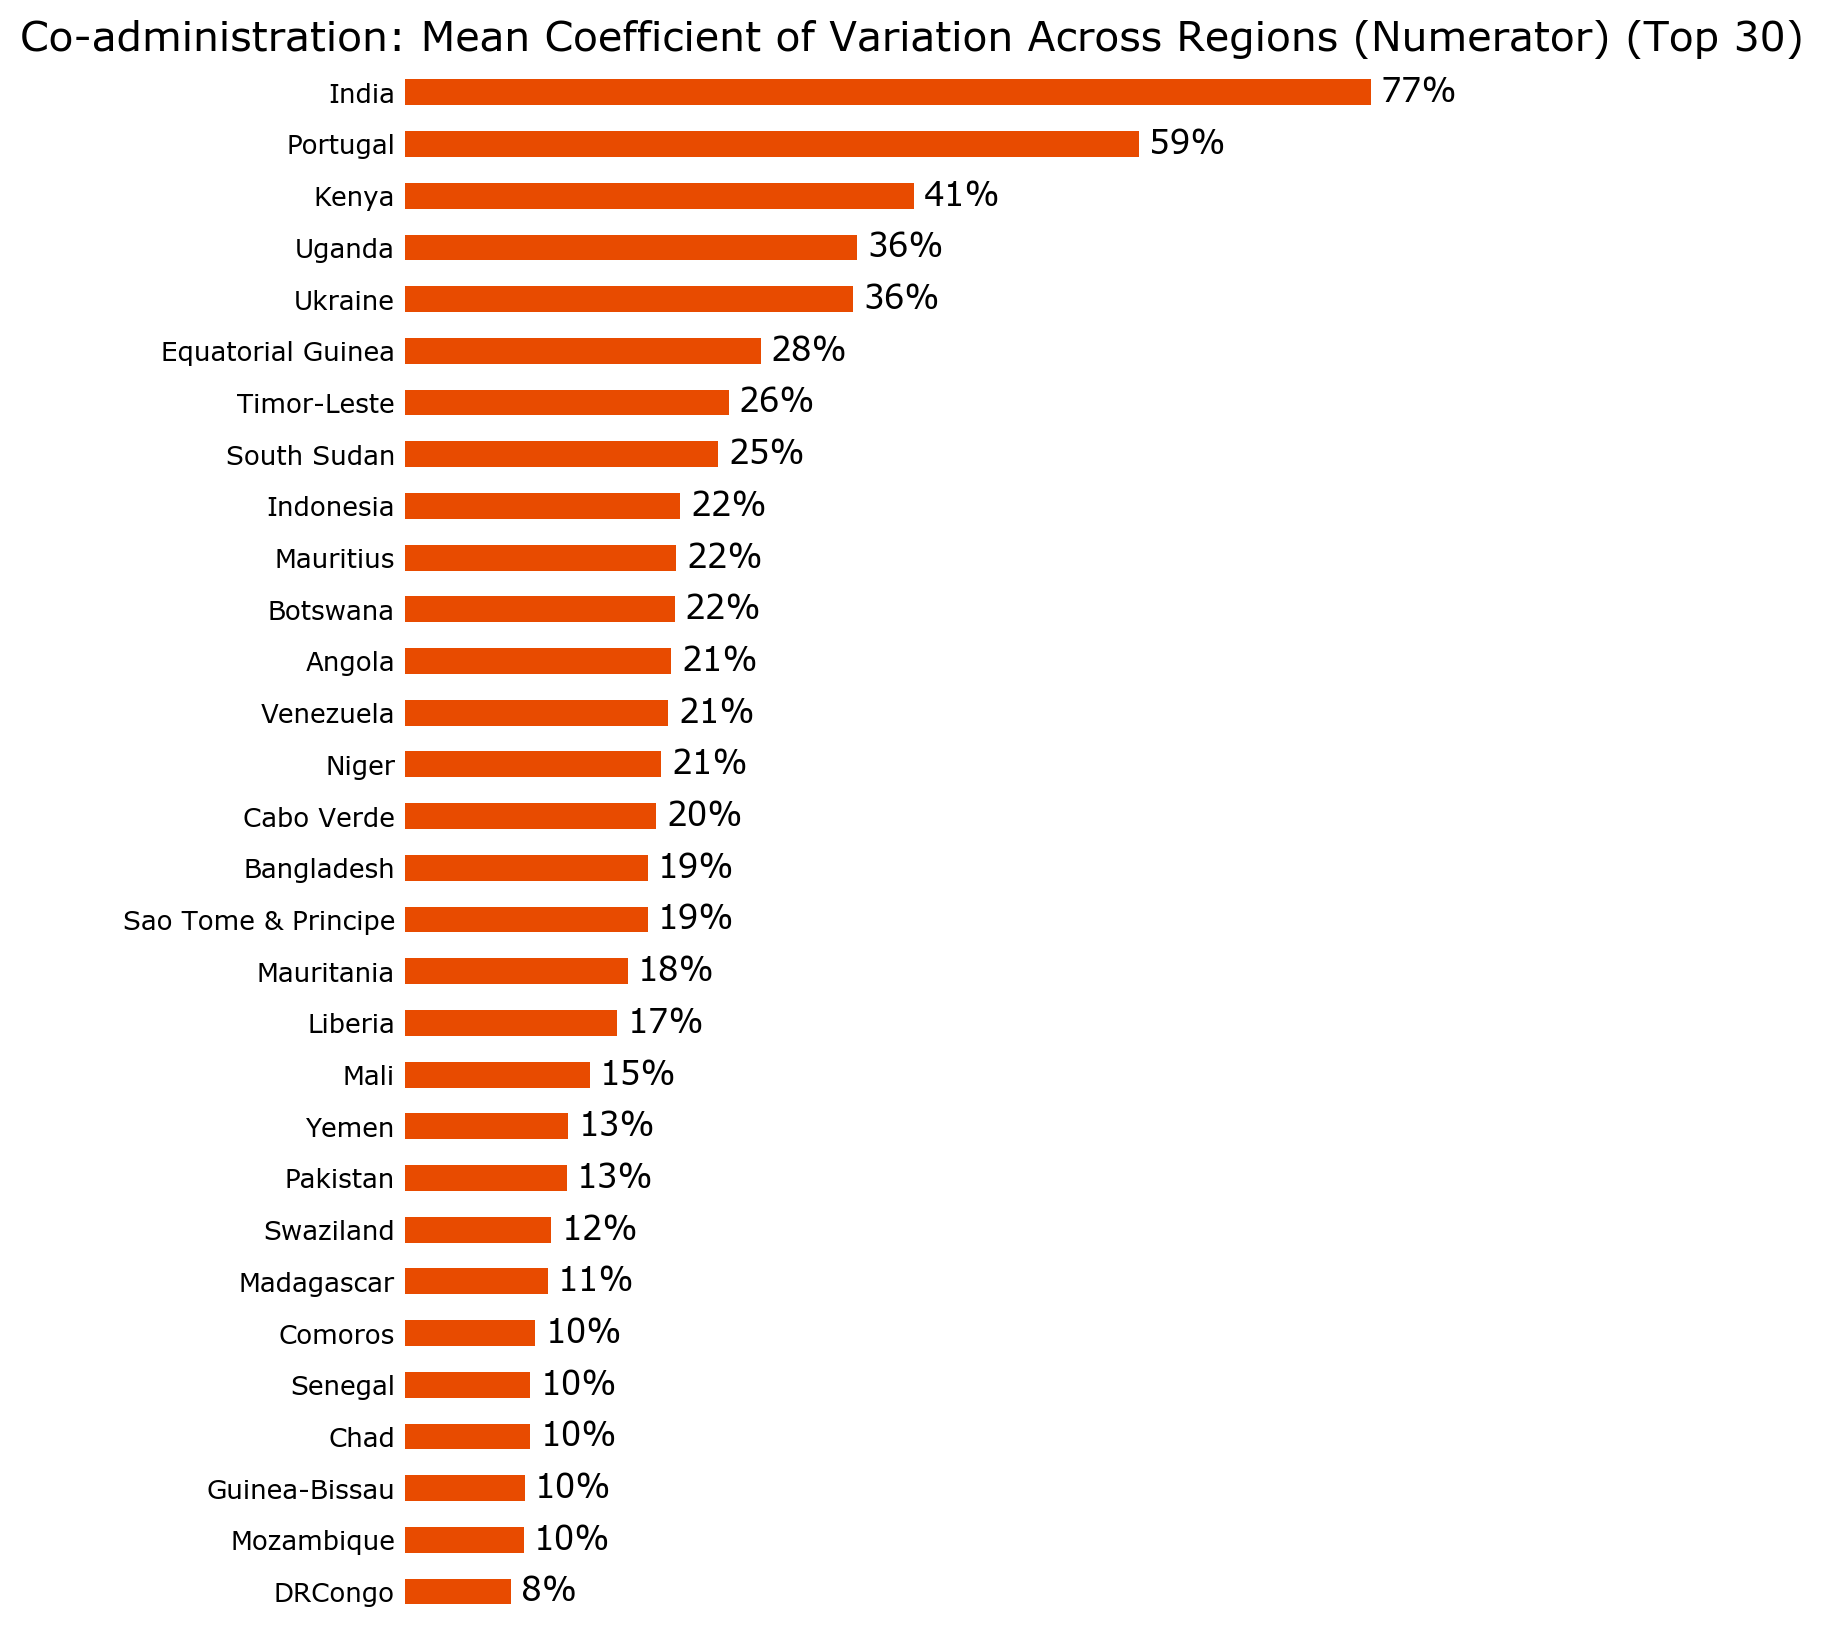

In [6]:
to_plot = coef_var
PLOT_LIM = 30
FS=12

with styled_fig_ax(size='tallest', font_size=FS, x_formatter=pct_func_formatter(), zero_lines=False) as ax:
    labeled_bar(ax,
                to_plot.head(PLOT_LIM).sort_values().rename(index=code_to_name),
                font_size=FS,
                horizontal=True,
                label_formatter=pct_func_formatter(),
                color=PALETTE['orange']
               )
    
    
    ax.set_ylabel('')
    ax.set_title('Co-administration: Mean Coefficient of Variation Across Regions (Numerator) (Top {})'.format(PLOT_LIM))

### Coefficient of Variation Denoms

In [ ]:
who_df.Den

In [30]:
(who_df.groupby(['Iso Code', 'available_admin', 'timing']).DenomType.nunique() != 1).sum()

18600

In [31]:
# numerator error, adminstered at same time
coef_var = (who_df.groupby(['Iso Code', 'available_admin', 'DenomType'])
                  .Denominator
                  .agg(['mean', 'std'])
                  .assign(coef_of_var=lambda x: x['std'] / x['mean'])
                  .dropna()
                  .reset_index()
                  .groupby('Iso Code')
                  .coef_of_var
                  .mean()
                  .dropna()
                  .sort_values(ascending=False))

coef_var.name = 'coef_of_var_denom'
coef_var.to_frame().to_csv(Path('../data/processed/scores/country-internal-coef_of_var_denom.csv'))

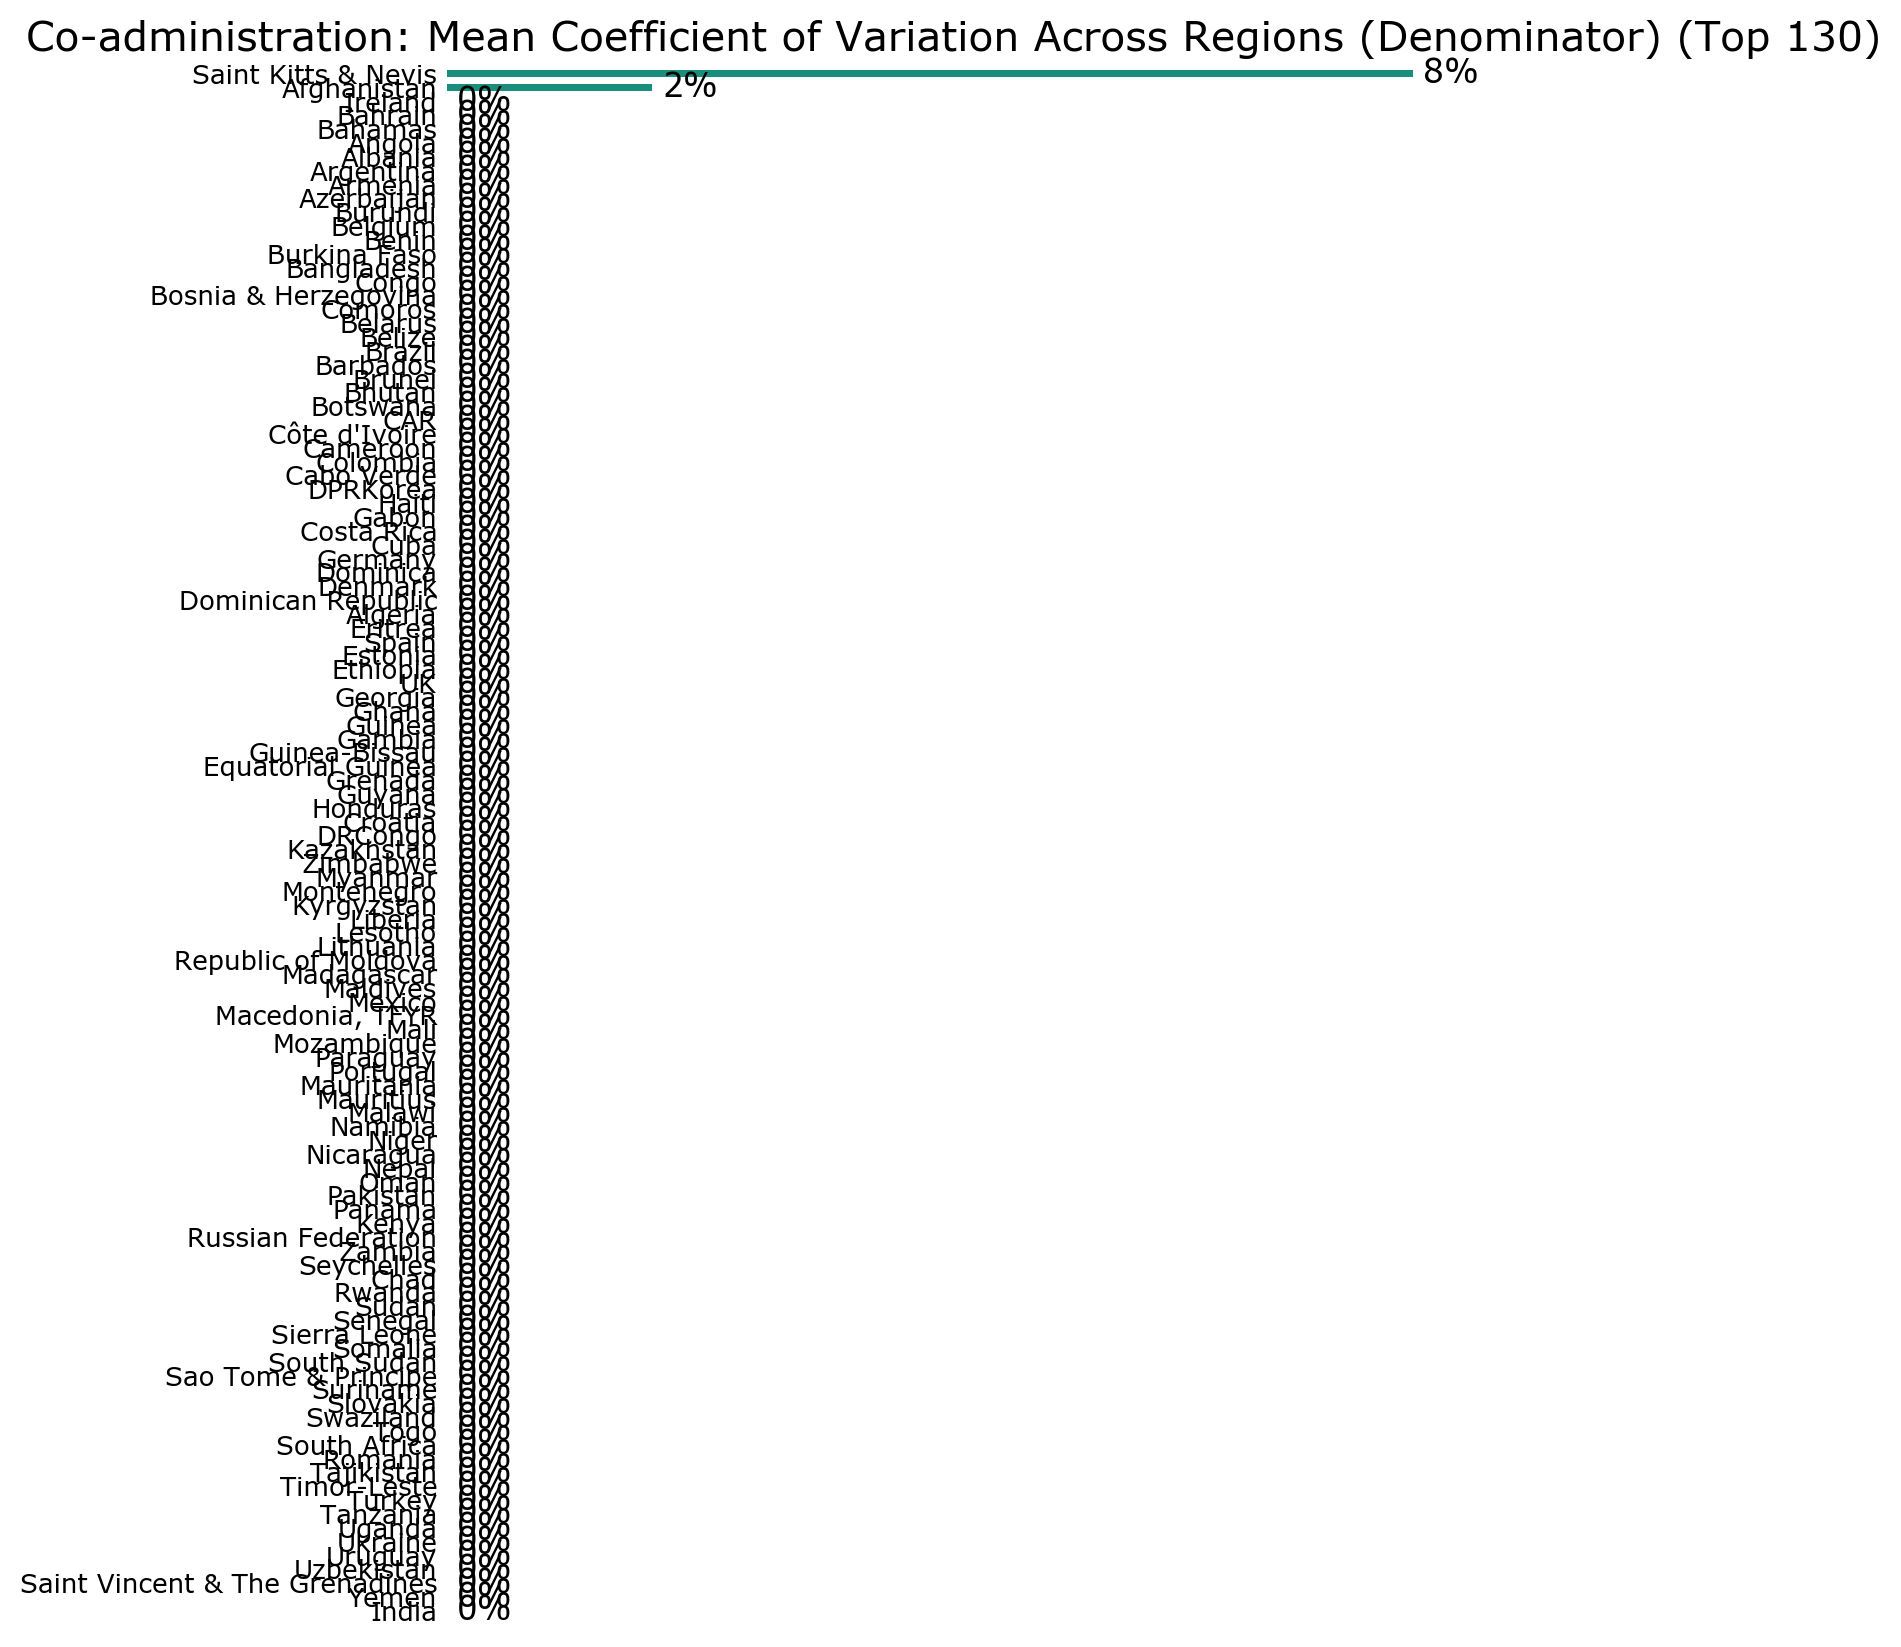

In [33]:
to_plot = coef_var
PLOT_LIM = 130
FS=12

with styled_fig_ax(size='tallest', font_size=FS, x_formatter=pct_func_formatter(), zero_lines=False) as ax:
    labeled_bar(ax,
                to_plot.head(PLOT_LIM).sort_values().rename(index=code_to_name),
                font_size=FS,
                horizontal=True,
                label_formatter=pct_func_formatter(),
                color=PALETTE['green']
               )
    
    
    ax.set_ylabel('')
    ax.set_title('Co-administration: Mean Coefficient of Variation Across Regions (Denominator) (Top {})'.format(PLOT_LIM))

### DTP Dropout - Averaged

In [9]:
dtp_dropout = who_df[who_df['Vaccine Type'].isin(['DTP1', 'DTP3'])]

dropout_averaged = (dtp_dropout.groupby(['Iso Code', 'available_admin', 'Vaccine Type'])
                                .agg({
                                    'recalc_numerator': 'first',
                                    'Denominator': 'first'
                                })
                                .assign(coverage=lambda x: x.recalc_numerator / x.Denominator)
                                .coverage
                                .unstack(-1)
                                .pipe(lambda x: 100 * (x.DTP1 - x.DTP3) / x.DTP1)
                                .abs()
                                .reset_index()
                                .groupby('Iso Code')
                                .mean()
                                [0])

dropout_averaged.name = 'dropout_averaged'
dropout_averaged.to_frame().to_csv(Path('../data/processed/scores/country-internal-dtp-dropout-averaged.csv'))




### DTP Dropout aggregated

In [14]:
dropout_agg

Iso Code
AFG    11.649611
AGO    12.408592
ALB    -0.888000
ARG    -5.098836
ARM     3.551024
AZE     1.003507
BDI     2.126579
BEL     1.280284
BEN     6.580388
BFA     3.317041
BGD     1.228457
BGR          NaN
BHR    -1.508250
BHS     2.963776
BIH    18.706036
BLR     1.306675
BLZ    -1.704807
BOL     6.444064
BRA     4.691155
BRB     3.627145
BRN     0.169675
BTN     0.262413
BWA    17.477494
CAF    31.709653
CHL     4.174818
CIV     1.988501
CMR     7.857510
COD     6.528472
COG     5.837627
COL     1.476188
         ...    
SEN     4.375717
SLE     5.523068
SLV          NaN
SOM    16.822964
SSD    23.527226
STP     1.404681
SUR     6.782420
SVK         -inf
SWE          NaN
SWZ     4.920535
SYC     2.490285
TCD    11.780745
TGO     3.689442
THA          NaN
TJK   -15.703321
TKM          NaN
TLS    -0.787439
TTO     0.257328
TUR    -7.492710
TZA     5.537345
UGA     6.972109
UKR         -inf
URY     2.865094
UZB    -4.620606
VCT    -2.258251
VEN    18.942523
YEM     2.389616
ZAF  

In [23]:
(dtp_dropout.groupby(['Iso Code', 'Vaccine Type'])
                                .agg({
                                    'recalc_numerator': 'sum',
                                    'Denominator': 'sum'
                                })
                                .pipe(lambda x: x.recalc_numerator / x.Denominator)
                                .unstack(-1)
                                .pipe(lambda x: 100 * (x.DTP1 - x.DTP3) / x.DTP1)).sort_values()

Iso Code
SVK          -inf
HRV          -inf
GBR          -inf
ESP          -inf
POL          -inf
PRT          -inf
UKR          -inf
ROU          -inf
RUS          -inf
SDN   -229.922903
KGZ    -21.854720
TJK    -15.703321
GEO     -8.690019
TUR     -7.492710
KNA     -7.413011
ARG     -5.098836
UZB     -4.620606
GRD     -4.020101
VCT     -2.258251
CUB     -2.186994
JAM     -1.936483
ECU     -1.746065
BLZ     -1.704807
BHR     -1.508250
CRI     -1.242458
NIC     -1.024358
ALB     -0.888000
TLS     -0.787439
DEU     -0.710331
MDV     -0.134216
          ...    
LBR     10.339100
KAZ     11.460134
AFG     11.649611
MLI     11.693148
DOM     11.713163
TCD     11.780745
AGO     12.408592
MRT     14.167131
PAN     15.335293
GTM     16.098847
SOM     16.822964
BWA     17.477494
GNB     18.703130
BIH     18.706036
VEN     18.942523
SSD     23.527226
CAF     31.709653
BGR           NaN
CZE           NaN
FRA           NaN
HUN           NaN
IRL           NaN
LVA           NaN
NLD           NaN
N

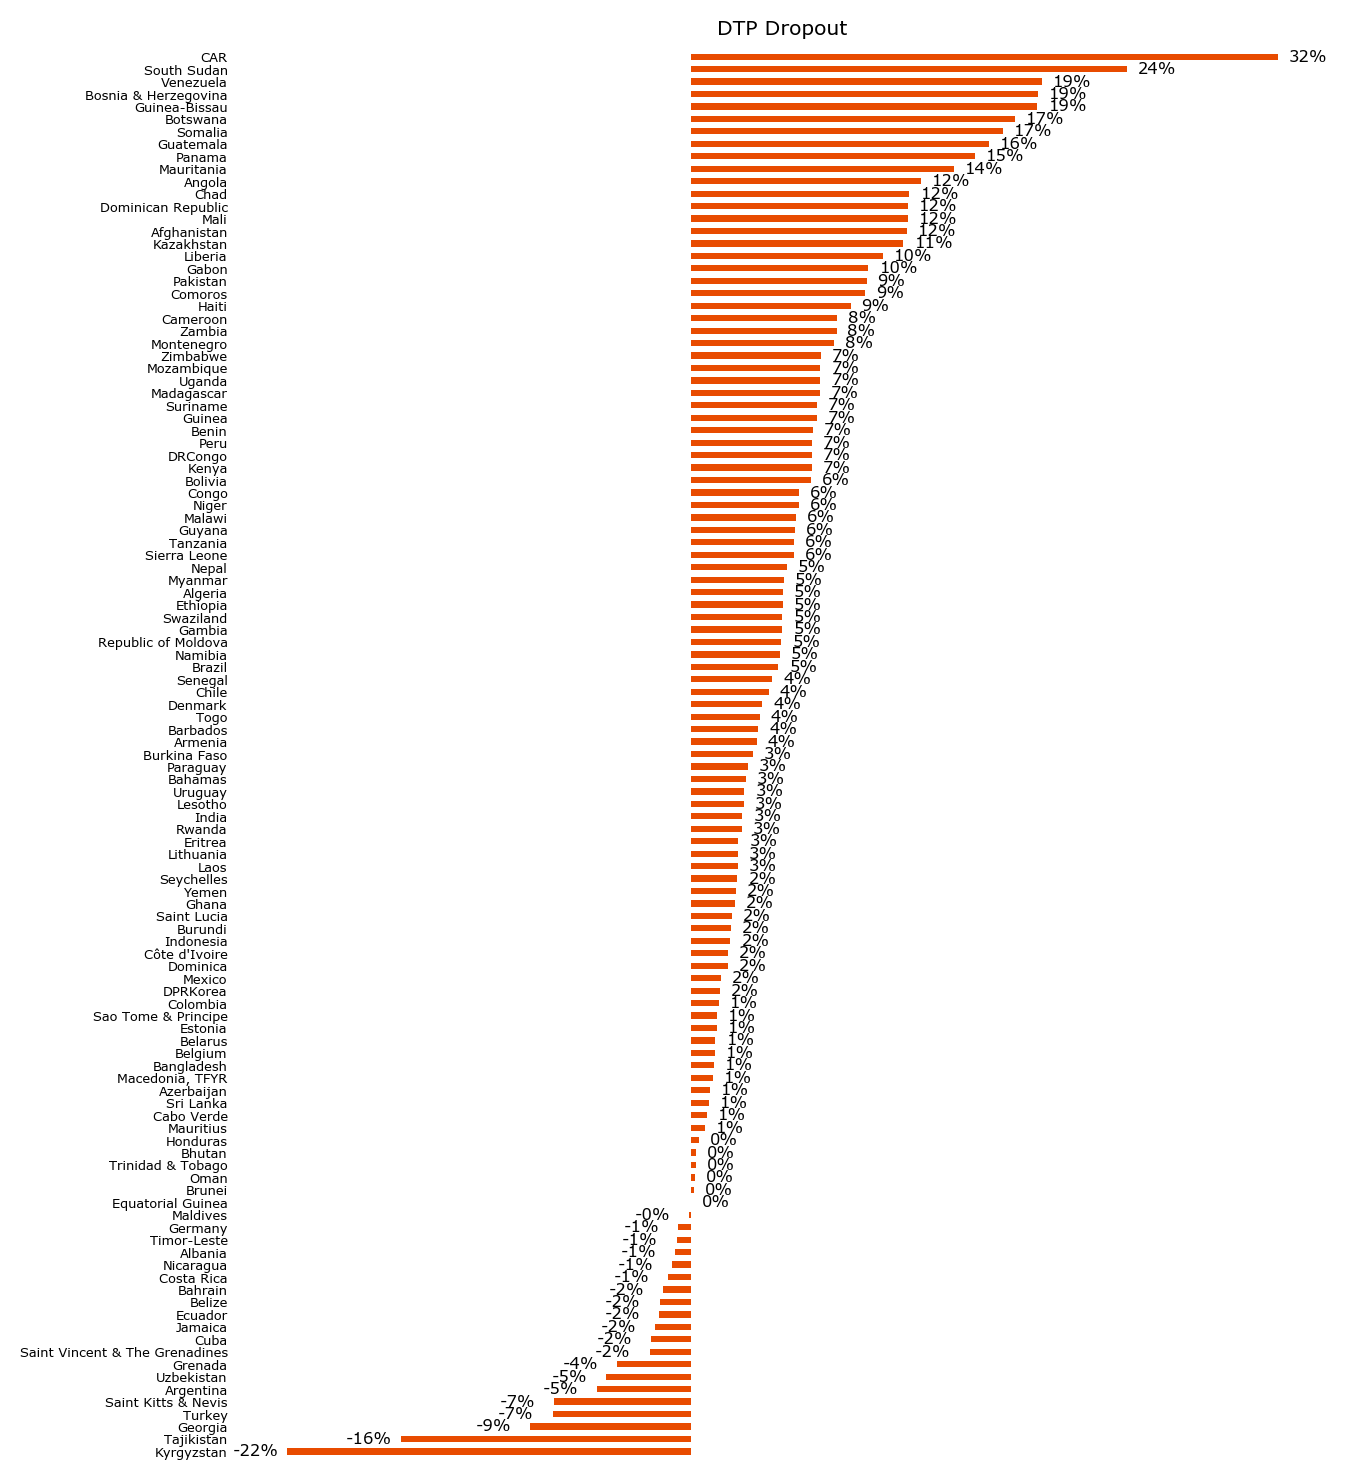

In [52]:
dtp_dropout = who_df[(who_df['Vaccine Type'].isin(['DTP1', 'DTP3']) &
                     (who_df['Iso Code'] != 'SDN'))]

with pd.option_context('mode.use_inf_as_null', True):
    dropout_agg = (dtp_dropout.groupby(['Iso Code', 'Vaccine Type'])
                                    .agg({
                                        'recalc_numerator': 'sum',
                                        'Denominator': 'sum'
                                    })
                                    .pipe(lambda x: x.recalc_numerator / x.Denominator)
                                    .unstack(-1)
                                    .dropna()
                                    .pipe(lambda x: 100 * (x.DTP1 - x.DTP3) / x.DTP1)
                                    .dropna())


dropout_agg.name = 'dropout_aggregated'
dropout_agg.to_frame().to_csv(Path('../data/processed/scores/country-internal-dtp-dropout-agg.csv'))

to_plot = dropout_agg

PLOT_LIM = 170
FS=6

with styled_fig_ax(size='tall', font_size=FS, x_formatter=pct_func_formatter(), zero_lines=False) as ax:
    labeled_bar(ax,
                to_plot.rename(index=code_to_name).head(PLOT_LIM).sort_values() / 100,
                font_size=FS,
                horizontal=True,
                label_formatter=pct_func_formatter(),
                color=PALETTE['orange']
               )
    
    ax.set_ylabel('')
    ax.set_title('DTP Dropout'.format(PLOT_LIM))

### MCV Dropout (UNUSED)

In [55]:
dropout = who_df[who_df['Vaccine Type'].isin(['MCV1', 'MCV2'])]

dropout[dropout['Country Name'] == 'Congo']

,Iso Code,Country Name,WHO Region,Year,Vaccine Type,Admin1,Admin2,DenomType,Denominator,Numerator,Coverage,recalc_numerator,available_admin,normalized_country,indicator,group,vaccine,timing,reported
51833,COG,Congo,AFRO,2016,MCV1,Bouenza,Loutete,2.0,2400.0,NaN,45.247618,1085.942828,Bouenza - Loutete,congo,1,Measles,MCV1,5th_9mos,True
51834,COG,Congo,AFRO,2016,MCV1,Bouenza,Madingou,2.0,4726.0,NaN,62.977450,2976.314272,Bouenza - Madingou,congo,1,Measles,MCV1,5th_9mos,True
51835,COG,Congo,AFRO,2016,MCV1,Bouenza,Mouyondzi,2.0,3253.0,NaN,56.387173,1834.274754,Bouenza - Mouyondzi,congo,1,Measles,MCV1,5th_9mos,True
51836,COG,Congo,AFRO,2016,MCV1,Bouenza,Nkayi,2.0,6366.0,NaN,46.699809,2972.909824,Bouenza - Nkayi,congo,1,Measles,MCV1,5th_9mos,True
51837,COG,Congo,AFRO,2016,MCV2,Bouenza,Loutete,2.0,2400.0,NaN,NaN,NaN,Bouenza - Loutete,congo,1,Measles,MCV2,NaN,False
51838,COG,Congo,AFRO,2016,MCV2,Bouenza,Madingou,2.0,4726.0,NaN,NaN,NaN,Bouenza - Madingou,congo,1,Measles,MCV2,NaN,False
51839,COG,Congo,AFRO,2016,MCV2,Bouenza,Mouyondzi,2.0,3253.0,NaN,NaN,NaN,Bouenza - Mouyondzi,congo,1,Measles,MCV2,NaN,False
51840,COG,Congo,AFRO,2016,MCV2,Bouenza,Nkayi,2.0,6366.0,NaN,NaN,NaN,Bouenza - Nkayi,congo,1,Measles,MCV2,NaN,False
52011,COG,Congo,AFRO,2016,MCV1,Brazzaville,Bacongo,2.0,5357.0,NaN,48.459064,2595.952064,Brazzaville - Bacongo,congo,1,Measles,MCV1,5th_9mos,True
52012,COG,Congo,AFRO,2016,MCV1,Brazzaville,Djiri,2.0,7920.0,NaN,41.085016,3253.933288,Brazzaville - Djiri,congo,1,Measles,MCV1,5th_9mos,True


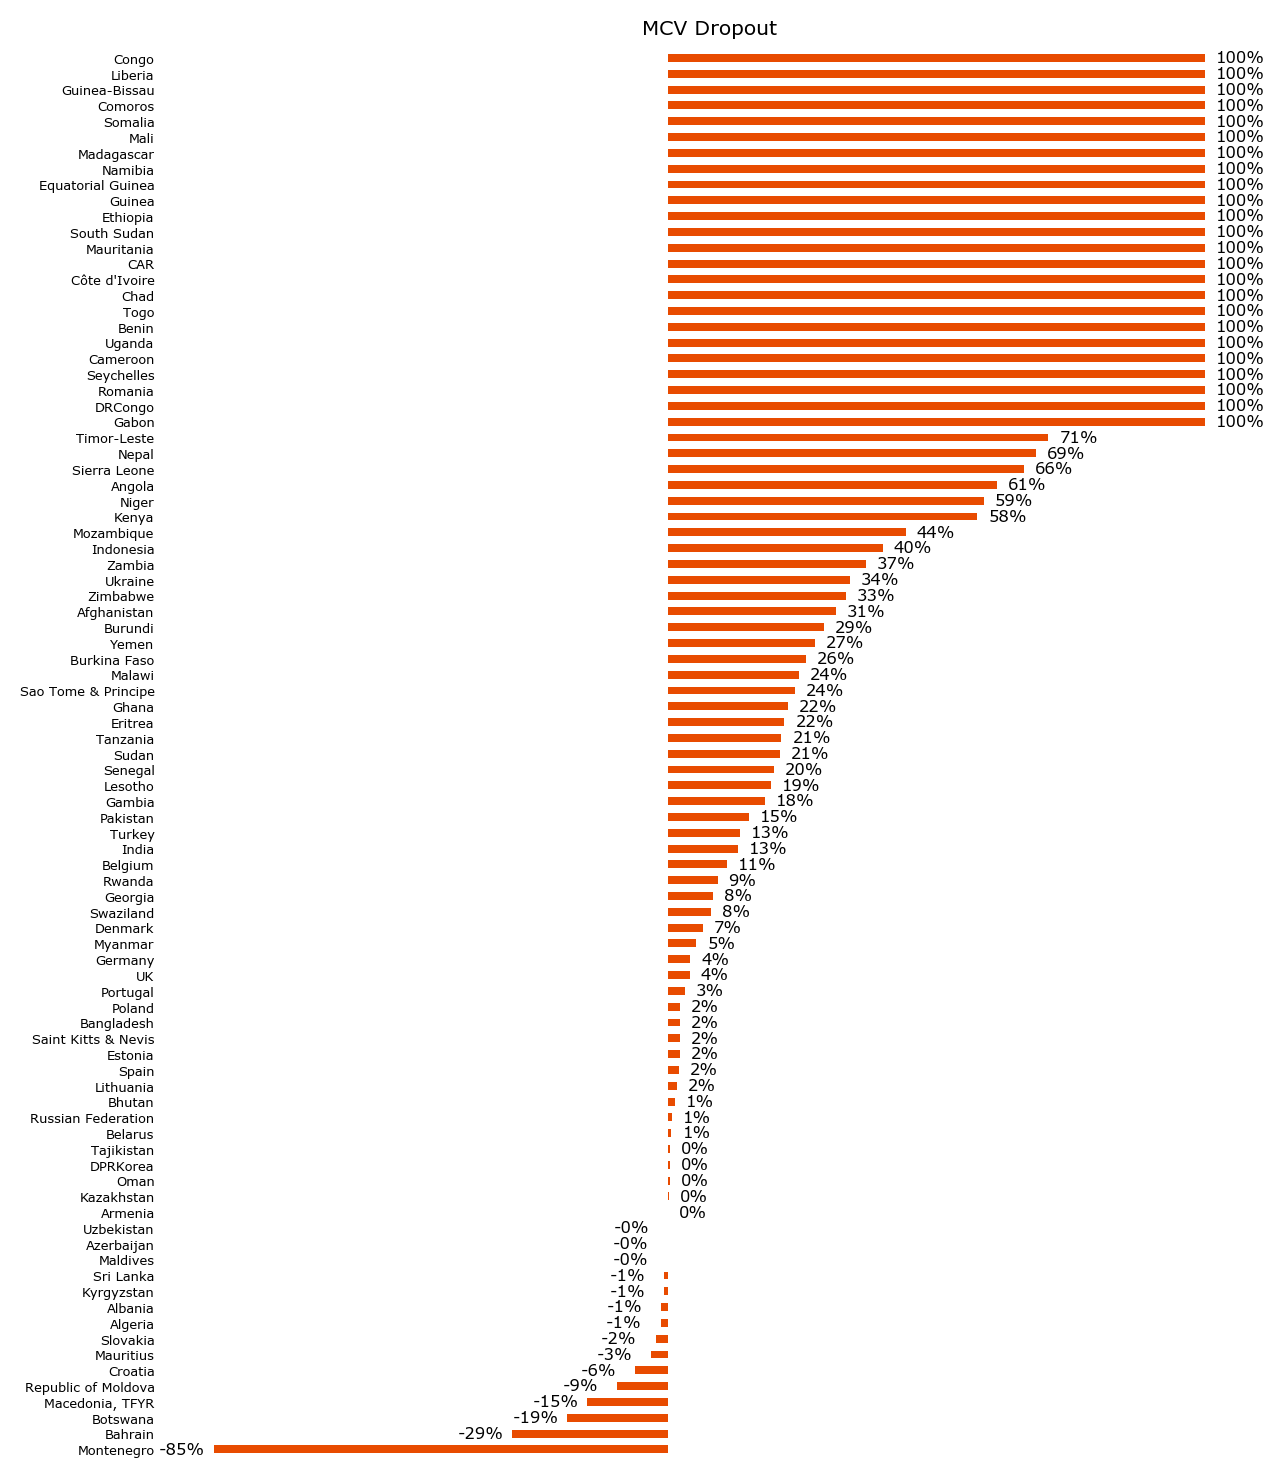

In [59]:
dropout = who_df[who_df['Vaccine Type'].isin(['MCV1', 'MCV2'])]

# dtp_dropout = who_df[(who_df['Vaccine Type'].isin(['DTP1', 'DTP3']) &
#                      (who_df['Iso Code'] != 'SDN'))]

with pd.option_context('mode.use_inf_as_null', True):
    dropout_agg = (dropout.groupby(['Iso Code', 'Vaccine Type'])
                                    .agg({
                                        'recalc_numerator': 'sum',
                                        'Denominator': 'sum'
                                    })
                                    .pipe(lambda x: x.recalc_numerator / x.Denominator)
                                    .unstack(-1)
                                    .dropna(how='any')
                                    .pipe(lambda x: 100 * (x.MCV1 - x.MCV2) / x.MCV1)
                                    .dropna())


to_plot = dropout_agg

PLOT_LIM = 170
FS=6

with styled_fig_ax(size='tall', font_size=FS, x_formatter=pct_func_formatter(), zero_lines=False) as ax:
    labeled_bar(ax,
                to_plot.rename(index=code_to_name).head(PLOT_LIM).sort_values() / 100,
                font_size=FS,
                horizontal=True,
                label_formatter=pct_func_formatter(),
                color=PALETTE['orange']
               )
    
    ax.set_ylabel('')
    ax.set_title('MCV Dropout'.format(PLOT_LIM))

In [12]:
samesies = np.intersect1d(mean_dropout.index.values, mean_dropout2.index.values)

pd.DataFrame({
    'rank_dtp': mean_dropout[samesies].rank(ascending=False),
    'rank_mcv': mean_dropout2[samesies].rank(ascending=False)
}).mean(axis=1).sort_values()


NameError: name 'mean_dropout' is not defined